# **Examples of Key value extraction and table extraction**

## **Imports**

In [1]:
## pip install oci PyMuPDF
## pip install pandas --upgrade

In [11]:
import oci
import base64
import uuid
import json
import fitz
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import IFrame

## **Set all variables**

In [12]:
name_of_pdf_file = "bank_statement_  1.pdf"
location_of_config = "C:/Users/Bob/Desktop/vscode/config"

### MAKE SURE TO CHANGE PRIVATE KEY IN YOUR CONFIG FILE

bucket_name = "West_BP"
namespace = "frqap2zhtzbe"
output_name_prefix = "DocumentUnderstanding_output"
compartment_ocid = "ocid1.compartment.oc1..aaaaaaaae3n6r6hrjipbap2hojicrsvkzatrtlwvsyrpyjd7wjnw4za3m75q"

# This is the OCI of your Custom model in OCI Document Understanding
MODEL_ID = "ocid1.aidocumentmodel.oc1.eu-frankfurt-1.amaaaaaangencdyany5dhod57upaemwitgsffjx4gmov2befya5wefck32rq"



## **Load Config file and private key**

In [13]:
# Check Authentication with OCI
def oci_authenticate(debug):
    
    # Set up and read in config file to authenticate against OCI
    config = oci.config.from_file(location_of_config, 'DEFAULT')

    # Create a Service Client to Identity API
    identity = oci.identity.IdentityClient(config)

    # Check if successful response received
    if identity.get_user(config['user']).status == 200:
        
        # Get the current User Information from API
        user = identity.get_user(config['user']).data

        if debug == 'y':
            print('\nAuthentication Successful!')
            print('\nOCI User Logged In:', user.name)
            print('OCI User Email:', user.email)
    else:
        print('Authentication Failed!')
        print('HTTP Request Error Code:', identity.get_user(config['user']).status)

    # Return config object to be used to initialise AI Language Client
    return config

# Authenticate against OCI
config = oci_authenticate('y')


Authentication Successful!

OCI User Logged In: oracleidentitycloudservice/bob.peulen@oracle.com
OCI User Email: None


## **Load .pdf file as Base64**

In [14]:
# Define PDF Document
document = name_of_pdf_file

# Remove Document Extension - Used later when save with new extension
document_no_ext = document[:-4]

# Encode PDF Document as base64
with open(document, "rb") as document_file:
    document_encoded = base64.b64encode(document_file.read()).decode('utf-8')

## **Key Value Extractions**

### **Function 1 - Invoke the (custom) Key Value Extractions model** 

In [15]:
def kv_extraction(config, document_encoded):
    
    # Compartment where Processor Job will be created
    COMPARTMENT_ID = compartment_ocid
     
    ### bank statement mode
    
    # Define AI Services Client
    aiservicedocument_client = oci.ai_document.AIServiceDocumentClient(config=config)
    print(aiservicedocument_client)
    
    # Instantiate Document Key-Value Feature - Pass in Model ID
    key_value_extraction_feature = oci.ai_document.models.DocumentKeyValueExtractionFeature(model_id=MODEL_ID)

    # Save to a list - add multiple DUS features here if required
    features = [key_value_extraction_feature]
    
    # Define Document Input
    input_loc = oci.ai_document.models.InlineDocumentContent(data=document_encoded)
    
    # Setup the Output Location where the Job Results will be stored
    output_location = oci.ai_document.models.OutputLocation()
    output_location.namespace_name = namespace
    output_location.bucket_name = bucket_name
    output_location.prefix = output_name_prefix


    # Define the Features for DUS
    processor_config = oci.ai_document.models.GeneralProcessorConfig(features=features)
    
    # Create a Job for Key Value Extraction Feature
    kv_job_details = oci.ai_document.models.CreateProcessorJobDetails(
                        display_name=str(uuid.uuid4()),
                        compartment_id=COMPARTMENT_ID,
                        input_location=input_loc,
                        output_location=output_location,
                        processor_config=processor_config)

    # Extecute DUS Job - Response is an Object pointing to Deatils of Job
    processor_response = aiservicedocument_client.create_processor_job(create_processor_job_details=kv_job_details)

    print("Processor call succeeded with status: {}.\n\n".format(processor_response.status))
    
    
    return processor_response, output_location
    
    
# Call Key Value Extraction Function
processor_response, output_location = kv_extraction(config, document_encoded)

Processor call succeeded with status: 201.




## **Retrieve and parse results from object storage**

The output json from the model is stored in object storage

In [16]:
def retrieve_results(config, processor_response, output_location):
    
    # Get Job ID from Response
    processor_job_id = processor_response.data.id

    # Instantiate Object Storage Client
    object_storage_client = oci.object_storage.ObjectStorageClient(config=config)

    # Getting Results from Object Storage
    object_response = object_storage_client.get_object(namespace_name=output_location.namespace_name,
                                                           bucket_name=output_location.bucket_name,
                                                           object_name="{}/{}/_/results/defaultObject.json".format(
                                                               output_location.prefix, processor_job_id))
    
    # Decode Response
    result = str(object_response.data.content.decode())

    # Convert Response to Python Dictionary
    result_dict = json.loads(result)
    
    return result_dict


# Retrieve Results from Object Storage
result_dict = retrieve_results(config, processor_response, output_location)

In [17]:
print(result_dict)

{'documentMetadata': {'pageCount': 1, 'mimeType': 'application/pdf'}, 'pages': [{'pageNumber': 1, 'dimensions': {'width': 2481.0, 'height': 3508.0, 'unit': 'PIXEL'}, 'detectedDocumentTypes': None, 'detectedLanguages': None, 'words': [{'text': 'ABC', 'confidence': 0.9989457, 'boundingPolygon': {'normalizedVertices': [{'x': 0.11164852881902458, 'y': 0.0952109464082098}, {'x': 0.15276098347440548, 'y': 0.0952109464082098}, {'x': 0.15276098347440548, 'y': 0.10974914481185861}, {'x': 0.11164852881902458, 'y': 0.10974914481185861}]}}, {'text': 'Land', 'confidence': 0.9606286, 'boundingPolygon': {'normalizedVertices': [{'x': 0.2192664248286981, 'y': 0.09948688711516533}, {'x': 0.25594518339379285, 'y': 0.09948688711516533}, {'x': 0.25594518339379285, 'y': 0.11117445838084379}, {'x': 0.2192664248286981, 'y': 0.11117445838084379}]}}, {'text': 'River,', 'confidence': 0.9606286, 'boundingPolygon': {'normalizedVertices': [{'x': 0.25675130995566303, 'y': 0.09948688711516533}, {'x': 0.30471584038694

## **Visualize results in PDF and in table**

C:\Users\Bob\AppData\Local\Temp\ipykernel_26588\165251906.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = results_df._append(a_series, ignore_index=True)


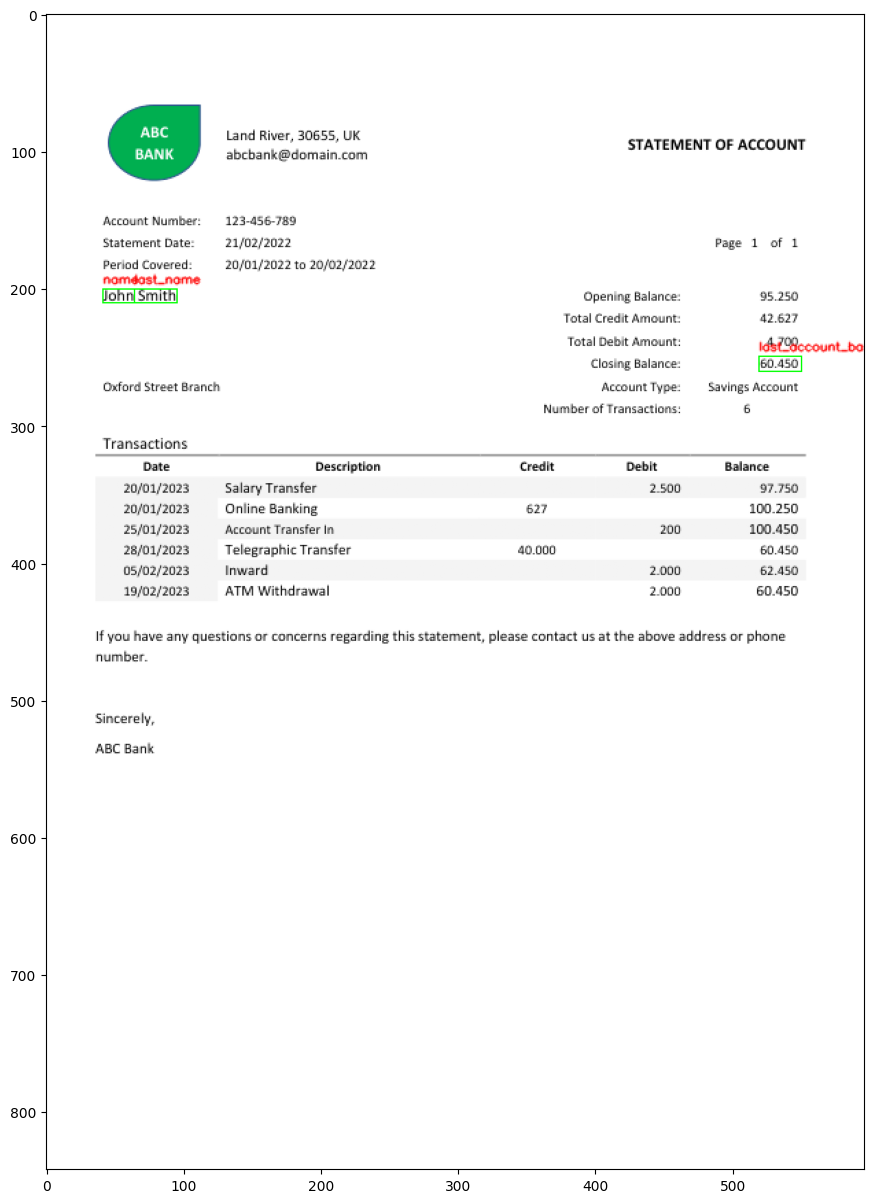

,Page,Label,Value,Condifence
0,1,name,John,89.45
1,1,last_name,Smith,81.84
2,1,last_account_balance,60.450,74.57


In [18]:
def parse_results_visualise(result_dict, document, document_no_ext, show_output):

    # Open PDF Document - Ready to convert to PNG
    pages = fitz.open(document)

    # Iterate through the Pages
    for page in pages:  
        # Convert to Image
        pix = page.get_pixmap()
        # Save as PNG File
        pix.save(f"{document_no_ext}-image-{page.number + 1}.png")
        
        
    # Create Empty DataFrame
    results_df = pd.DataFrame([], columns = ["Page", "Label", "Value", "Condifence"])

    # Iterate over Pages
    for page in result_dict['pages']:

        # Read in Image
        im = cv2.imread(f"{document_no_ext}-image-{page['pageNumber']}.png")

        # Get Dimensions of Image - For Scaling Later
        height, width, channels = im.shape

        # Iterate over Key Value Pairs and Respective Bounding Boxes
        for kv_pair in page['documentFields']:

            # Extract Relevant Data
            name = kv_pair['fieldLabel']['name']
            value = kv_pair['fieldValue']['value']
            confidence = round(kv_pair['fieldLabel']['confidence']*100, 2)

            # Add Key Values to Results List
            results_list = [page['pageNumber'], name, value, confidence]

            # Append to Results List to DataFrame
            a_series = pd.Series(results_list, index = results_df.columns)
            results_df = results_df._append(a_series, ignore_index=True)

            # Extract Bounding Boxes
            bounding_polygon_x1 = int(kv_pair['fieldValue']['boundingPolygon']['normalizedVertices'][0]['x']*width)
            bounding_polygon_y1 = int(kv_pair['fieldValue']['boundingPolygon']['normalizedVertices'][0]['y']*height)
            bounding_polygon_x2 = int(kv_pair['fieldValue']['boundingPolygon']['normalizedVertices'][2]['x']*width)
            bounding_polygon_y2 = int(kv_pair['fieldValue']['boundingPolygon']['normalizedVertices'][2]['y']*height)

            # Build Points as Tuples - Coordinates of Opposite Points
            coordinates_pt1 = (bounding_polygon_x1, bounding_polygon_y1)
            coordinates_pt2 = (bounding_polygon_x2, bounding_polygon_y2)

            # Draw Bounding Boxes - Pass in Image, Top Left and Bottom Right Points, Colour, Line Thickness
            cv2.rectangle(im, coordinates_pt1, coordinates_pt2, (0, 255, 0), 1)

            # Plot Label just above the Top Left Point, Set Font, Size, Colour, Thickness, Line Type
            cv2.putText(im, name, (bounding_polygon_x1, bounding_polygon_y1-4), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,255), 1, cv2.LINE_AA)

            # Write Image with Bounding Boxes to file
            cv2.imwrite(f"{document_no_ext}-result-{page['pageNumber']}.png",im)
            
    
    if show_output == 'Y':
        # Iterate over Pages
        for page in result_dict['pages']:

            # Create Figure and Set Size
            fig = plt.figure()
            fig.set_size_inches(12, 15)

            # Read in Image
            img = mpimg.imread(f"{document_no_ext}-result-{page['pageNumber']}.png")

            # Plot Image
            imgplot = plt.imshow(img)
            plt.show(imgplot)
            

    return results_df



# Parse Results and Visualise Outputs
results_df = parse_results_visualise(result_dict, document, document_no_ext, 'Y')

# Preview Data
results_df.head(10)

## **Table Extraction**

In [29]:
def table_extraction(config, document_encoded):
    
    # Compartment where Processor Job will be created
    COMPARTMENT_ID = compartment_ocid
     
    ### bank statement mode
    
    # Define AI Services Client
    aiservicedocument_client = oci.ai_document.AIServiceDocumentClient(config=config)
    print(aiservicedocument_client)
    
    # Instantiate Document Key-Value Feature - Pass in Model ID
    #table_extraction_feature = oci.ai_document.models.DocumentTableExtractionFeature(model_id=MODEL_ID)
    table_extraction_feature = oci.ai_document.models.DocumentTableExtractionFeature() #no model is means default pre-trained model

    # Save to a list - add multiple DUS features here if required
    features = [table_extraction_feature]
    
    # Define Document Input
    input_loc = oci.ai_document.models.InlineDocumentContent(data=document_encoded)
    
    # Setup the Output Location where the Job Results will be stored
    output_location = oci.ai_document.models.OutputLocation()
    output_location.namespace_name = namespace
    output_location.bucket_name = bucket_name
    output_location.prefix = output_name_prefix


    # Define the Features for DUS
    processor_config = oci.ai_document.models.GeneralProcessorConfig(features=features)
    
    # Create a Job for Key Value Extraction Feature
    kv_job_details = oci.ai_document.models.CreateProcessorJobDetails(
                        display_name=str(uuid.uuid4()),
                        compartment_id=COMPARTMENT_ID,
                        input_location=input_loc,
                        output_location=output_location,
                        processor_config=processor_config)

    # Extecute DUS Job - Response is an Object pointing to Deatils of Job
    processor_response = aiservicedocument_client.create_processor_job(create_processor_job_details=kv_job_details)

    print("Processor call succeeded with status: {}.\n\n".format(processor_response.status))
    
    
    return processor_response, output_location
    
    
# Call Key Value Extraction Function
processor_response_table, output_location_table = table_extraction(config, document_encoded)

Processor call succeeded with status: 201.




In [31]:
print(processor_response_table.data)

{
  "compartment_id": "ocid1.compartment.oc1..aaaaaaaae3n6r6hrjipbap2hojicrsvkzatrtlwvsyrpyjd7wjnw4za3m75q",
  "display_name": "24dfbeee-40dd-46f4-a0d6-597892384ee7",
  "id": "ocid1.aidocumentprocessorjob.oc1.eu-frankfurt-1.amaaaaaangencdyav2myrmwxsduxaay22x5yahtbhzdcu7es3i7vfiwqdrda",
  "input_location": {
    "data": "JVBERi0xLjcNCiW1tbW1DQoxIDAgb2JqDQo8PC9UeXBlL0NhdGFsb2cvUGFnZXMgMiAwIFIvTGFuZyhubC1OTCkgL1N0cnVjdFRyZWVSb290IDE5IDAgUi9NYXJrSW5mbzw8L01hcmtlZCB0cnVlPj4vTWV0YWRhdGEgMzM2IDAgUi9WaWV3ZXJQcmVmZXJlbmNlcyAzMzcgMCBSPj4NCmVuZG9iag0KMiAwIG9iag0KPDwvVHlwZS9QYWdlcy9Db3VudCAxL0tpZHNbIDMgMCBSXSA+Pg0KZW5kb2JqDQozIDAgb2JqDQo8PC9UeXBlL1BhZ2UvUGFyZW50IDIgMCBSL1Jlc291cmNlczw8L0ZvbnQ8PC9GMSA1IDAgUi9GMiA5IDAgUi9GMyAxMSAwIFIvRjQgMTMgMCBSPj4vRXh0R1N0YXRlPDwvR1M3IDcgMCBSL0dTOCA4IDAgUj4+L1Byb2NTZXRbL1BERi9UZXh0L0ltYWdlQi9JbWFnZUMvSW1hZ2VJXSA+Pi9NZWRpYUJveFsgMCAwIDU5NS4zMiA4NDEuOTJdIC9Db250ZW50cyA0IDAgUi9Hcm91cDw8L1R5cGUvR3JvdXAvUy9UcmFuc3BhcmVuY3kvQ1MvRGV2aWNlUkdCPj4vVGFicy9TL1N0cnVjdFBhcmVudH

In [32]:
def retrieve_results_table(config, processor_response_table, output_location_table):
    
    # Get Job ID from Response
    processor_job_id = processor_response.data.id

    # Instantiate Object Storage Client
    object_storage_client = oci.object_storage.ObjectStorageClient(config=config)

    # Getting Results from Object Storage
    object_response = object_storage_client.get_object(namespace_name=output_location.namespace_name,
                                                           bucket_name=output_location.bucket_name,
                                                           object_name="{}/{}/_/results/defaultObject.json".format(
                                                               output_location.prefix, processor_job_id))
    
    # Decode Response
    result = str(object_response.data.content.decode())

    # Convert Response to Python Dictionary
    result_dict = json.loads(result)
    
    return result_dict


# Retrieve Results from Object Storage
result_dict = retrieve_results_table(config, processor_response_table, output_location_table)

In [33]:
result_dict

{'documentMetadata': {'pageCount': 1, 'mimeType': 'application/pdf'},
 'pages': [{'pageNumber': 1,
   'dimensions': {'width': 8.268333333333334,
    'height': 11.693333333333333,
    'unit': 'INCH'},
   'detectedDocumentTypes': None,
   'detectedLanguages': None,
   'words': [{'text': 'ABC',
     'confidence': 0.99874765,
     'boundingPolygon': {'normalizedVertices': [{'x': 0.1124546553808948,
        'y': 0.09576742197520308},
       {'x': 0.1523579201934704, 'y': 0.09576742197520308},
       {'x': 0.1523579201934704, 'y': 0.10902094912355707},
       {'x': 0.1124546553808948, 'y': 0.10902094912355707}]}},
    {'text': 'Land',
     'confidence': 0.9850211,
     'boundingPolygon': {'normalizedVertices': [{'x': 0.22128174123337363,
        'y': 0.09961522017956391},
       {'x': 0.25574365175332525, 'y': 0.09961522017956391},
       {'x': 0.25574365175332525, 'y': 0.10987601539119282},
       {'x': 0.22128174123337363, 'y': 0.10987601539119282}]}},
    {'text': 'River,',
     'confiden